In [2]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering & preprocessing
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

# Model training & evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    classification_report,
    make_scorer
)

# Feature selection & interpretation
from sklearn.feature_selection import mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import shap

C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Function

In [3]:
def plot_feature_distributions(dataframe, n_cols=3, fig_width=15, row_height=4, 
                              kde=True, color='skyblue', title_prefix='Distribution of '):
    """
    Plots distribution histograms for all columns in a DataFrame in a grid layout.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data to plot
    n_cols : int (default=3)
        Number of columns in the subplot grid
    fig_width : int (default=15)
        Width of the entire figure in inches
    row_height : int (default=4)
        Height of each row in inches
    kde : bool (default=True)
        Whether to show kernel density estimate
    color : str (default='skyblue')
        Color for the histograms
    title_prefix : str (default='Distribution of ')
        Prefix for each subplot title
    """
    # Calculate grid dimensions
    n_features = len(dataframe.columns)
    n_rows = (n_features - 1) // n_cols + 1
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, n_rows * row_height))
    fig.tight_layout(pad=3.0)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot histograms for each feature
    for i, column in enumerate(dataframe.columns):
        sns.histplot(data=dataframe, x=column, kde=kde, color=color, ax=axes[i])
        axes[i].set_title(f'{title_prefix}{column}')
        axes[i].set_xlabel('')
        
        # Rotate x-tick labels if they're too long
        if len(dataframe[column].unique()) < 10:  # For categorical features
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [4]:
def balanced_recall_accuracy(y_true, y_pred, alpha=0.7):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return alpha * recall_class1 + (1 - alpha) * accuracy  # Weighted sum

In [5]:
def plot_correlation_matrix(df, title='Correlation Matrix', figsize=(10, 8), cmap='coolwarm'):
    """
    Plots a correlation matrix for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.
        cmap (str): The colormap to use.

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
    plt.title(title)
    plt.show()

In [6]:
def plot_pairplot(df, hue=None, title='Pairplot', figsize=(10, 8)):
    """
    Plots a pairplot for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        hue (str): The column name to use for color coding.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.

    Returns:
        None
    """
    sns.pairplot(df, hue=hue)
    plt.suptitle(title, y=1.02)
    plt.show()

In [7]:
def plot_feature_distributions(dataframe, n_cols=3, fig_width=15, row_height=4, 
                              kde=True, color='skyblue', title_prefix='Distribution of '):
    """
    Plots distribution histograms for all columns in a DataFrame in a grid layout.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data to plot
    n_cols : int (default=3)
        Number of columns in the subplot grid
    fig_width : int (default=15)
        Width of the entire figure in inches
    row_height : int (default=4)
        Height of each row in inches
    kde : bool (default=True)
        Whether to show kernel density estimate
    color : str (default='skyblue')
        Color for the histograms
    title_prefix : str (default='Distribution of ')
        Prefix for each subplot title
    """
    # Calculate grid dimensions
    n_features = len(dataframe.columns)
    n_rows = (n_features - 1) // n_cols + 1
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, n_rows * row_height))
    fig.tight_layout(pad=3.0)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot histograms for each feature
    for i, column in enumerate(dataframe.columns):
        sns.histplot(data=dataframe, x=column, kde=kde, color=color, ax=axes[i])
        axes[i].set_title(f'{title_prefix}{column}')
        axes[i].set_xlabel('')
        
        # Rotate x-tick labels if they're too long
        if len(dataframe[column].unique()) < 10:  # For categorical features
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [8]:
def balanced_recall_accuracy(y_true, y_pred, alpha=0.7):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return alpha * recall_class1 + (1 - alpha) * accuracy  # Weighted sum

In [9]:
def constrained_recall_scorer(y_true, y_pred):
    recall_0 = recall_score(y_true, y_pred, pos_label=0)  # Recall for Class 0
    accuracy = accuracy_score(y_true, y_pred)
    
    # Penalize if Class 0 recall < 0.6, else reward accuracy
    if recall_0 < 0.6:
        return -1  # Invalid solution (heavily penalized)
    else:
        return accuracy  # Or combine with Class 1 recall: (recall_0 + recall_score(y_true, y_pred, pos_label=1)) / 2

# Import data

In [10]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
file_path = 'Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

In [11]:
needs_df = pd.get_dummies(needs_df, columns=['Gender'], prefix='Gender')
needs_df.rename(columns={"Gender_0" : "Male", "Gender_1" : "Female"}, inplace=True)

# Accumulation Investment Product

In [12]:
df_accumulation = needs_df.copy()
df_accumulation = df_accumulation.drop(columns=['IncomeInvestment'])
df_accumulation.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,1,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,0,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,1,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


In [13]:
df_accumulation.corr(numeric_only=True)[['AccumulationInvestment']]

,AccumulationInvestment
Age,-0.013512
FamilyMembers,0.066606
FinancialEducation,0.067965
RiskPropensity,0.068420
Income,0.300324
Wealth,0.138393
AccumulationInvestment,1.000000
Male,0.010783
Female,-0.010783


## Comparison basis

In [14]:
df_accumulation

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,AccumulationInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,1,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,0,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,1,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False
...,...,...,...,...,...,...,...,...,...
4995,60,3,0.609411,0.588353,10.253281,57.368572,0,False,True
4996,65,3,0.523238,0.343272,104.155427,156.824602,1,False,True
4997,56,3,0.433826,0.402771,56.097301,63.283774,1,False,True
4998,51,3,0.559793,0.431419,62.523298,95.357528,0,False,True


In [15]:
X = df_accumulation.drop(columns=['AccumulationInvestment'])  # Features
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model without feature selection
# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7573
Precision: 0.8341

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       489
           1       0.83      0.76      0.79       511

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



## Feature Selection

In [16]:
feature_combinations = {
    'Wealth / Income': lambda df: df['Wealth'] * df['Income'],
    'Income / FamilyMembers': lambda df: df['Income'] / df['FamilyMembers'],
    'Wealth / FamilyMembers': lambda df: (df['Wealth']) / df['FamilyMembers'],
    'FinancialEducation * RiskPropensity': lambda df: df['FinancialEducation'] * df['RiskPropensity'],
    'FinancialEducation / RiskPropensity': lambda df: df['FinancialEducation'] / df['RiskPropensity']
}

# Create new features based on the combinations defined above
for feature_name, func in feature_combinations.items():
    df_accumulation[feature_name] = func(df_accumulation)
df_accumulation.drop(columns=['Male', 'Female', 'FamilyMembers'], inplace=True)

## Forward Feature Selection

In [17]:
X = df_accumulation.drop(columns=['AccumulationInvestment'])  # Features
y = df_accumulation['AccumulationInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
custom_scorer = make_scorer(constrained_recall_scorer)

# Initialize SFS with the custom scorer
sfs = SFS(
    RandomForestClassifier(random_state=42),
    k_features="best",
    forward=True,
    scoring=custom_scorer,  # Use the custom scorer
    cv=StratifiedKFold(5),  # Stratified K-Folds cross-validator
    n_jobs=-1,
    verbose=2
)

# Fit on training data
sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    5.8s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.3s finished

[2025-04-09 04:00:40] Features: 1/10 -- score: -0.68225[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:    3.3s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    4.0s finished

[2025-04-09 04:00:44] Features: 2/10 -- score: 0.752[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.7s finished

[2025-04-09 04:00:47] Features: 3/10 -- score: 0.7582500000000001[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    3.2s

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          k_features=(1, 10), n_jobs=-1,
                          scoring=make_scorer(constrained_recall_scorer, response_method='predict'),
                          verbose=2)

In [19]:
# Get the best subset's performance
best_subset_key = list(sfs.subsets_.keys())[-1]  # The last key is the best subset
best_subset = sfs.subsets_[best_subset_key]

print("Best features:", sfs.k_feature_names_)
print("CV Recall (custom scorer):", best_subset['avg_score'])
print("CV Accuracy:", np.mean(best_subset['cv_scores']))  # Average across folds

Best features: ('Age', 'FinancialEducation', 'Income', 'Wealth', 'Wealth / Income', 'FinancialEducation * RiskPropensity')
CV Recall (custom scorer): 0.79425
CV Accuracy: 0.79425


In [20]:
# Model without feature selection
selected_features = list(sfs.k_feature_names_)
rf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = rf.predict(X_test[selected_features])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7397
Precision: 0.8552

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       489
           1       0.86      0.74      0.79       511

    accuracy                           0.80      1000
   macro avg       0.81      0.80      0.80      1000
weighted avg       0.81      0.80      0.80      1000



## Exhaustive Feature Selection

In [21]:
# Initialize EFS
efs_accumulation = EFS(
    RandomForestClassifier(random_state=42),
    min_features=3,          # Minimum features to test
    max_features=10,          # Maximum features to test (keep ≤4 for practicality)
    scoring=custom_scorer,        # Optimize recall (or 'accuracy', 'f1', etc.)
    cv=StratifiedKFold(5),                    # Cross-validation folds
    n_jobs=-1,               # Use all CPU cores
)

# Run EFS (this may take hours for large feature sets!)
efs_accumulation.fit(X_train, y_train)

Features: 968/968

ExhaustiveFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6],
                                          [7], [8], [9]],
                          max_features=10, min_features=3, n_jobs=-1,
                          scoring=make_scorer(constrained_recall_scorer, response_method='predict'))

In [22]:
# Results
print("Best feature subset:", efs_accumulation.best_idx_)          # Feature indices
print("Best feature names:", efs_accumulation.best_feature_names_) # Feature names
print("Best CV recall:", efs_accumulation.best_score_)             # Cross-validated recall

Best feature subset: (0, 1, 3, 4)
Best feature names: ('Age', 'FinancialEducation', 'Income', 'Wealth')
Best CV recall: 0.7997500000000001


In [23]:
# Model without feature selection
selected_features = list(efs_accumulation.best_feature_names_)
rf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = rf.predict(X_test[selected_features])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.7417
Precision: 0.8460

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       489
           1       0.85      0.74      0.79       511

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



## Data Set cleaning

In [27]:
selected_features_accumulation = ['Age', 'FinancialEducation', 'Income', 'Wealth']
df_accumulation_selected_features = df_accumulation[selected_features_accumulation + ['AccumulationInvestment']]
df_accumulation_selected_features.head()

,Age,FinancialEducation,Income,Wealth,AccumulationInvestment
0,60,0.228685,68.181525,53.260067,1
1,78,0.358916,21.807595,135.550048,0
2,33,0.317515,23.252747,66.303678,1
3,69,0.767685,166.189034,404.997689,1
4,58,0.429719,21.186723,58.911930,0


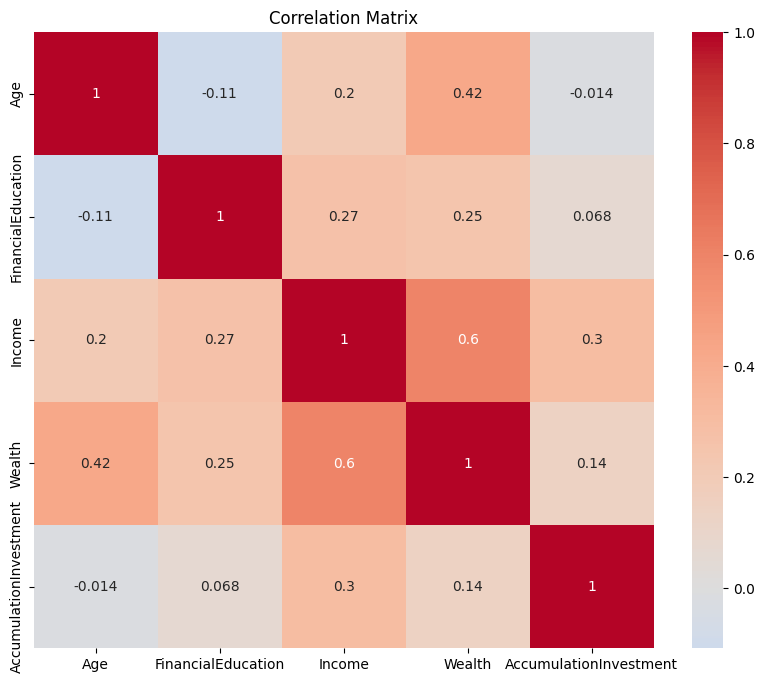

In [28]:
plot_correlation_matrix(df_accumulation_selected_features)

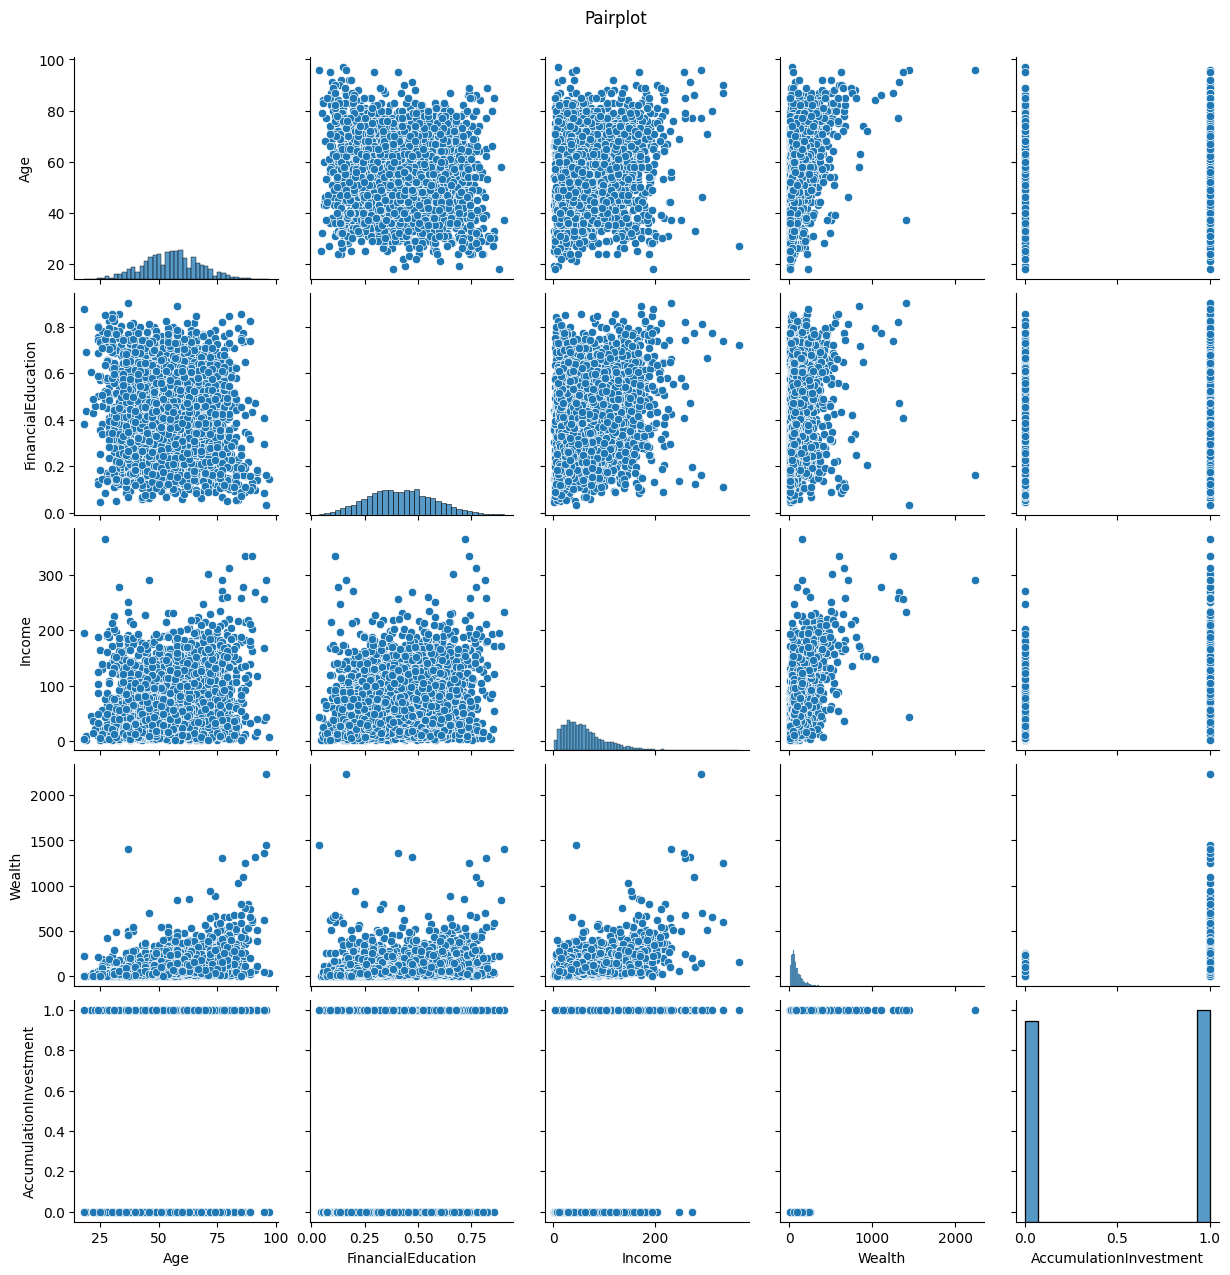

In [29]:
plot_pairplot(df_accumulation_selected_features)

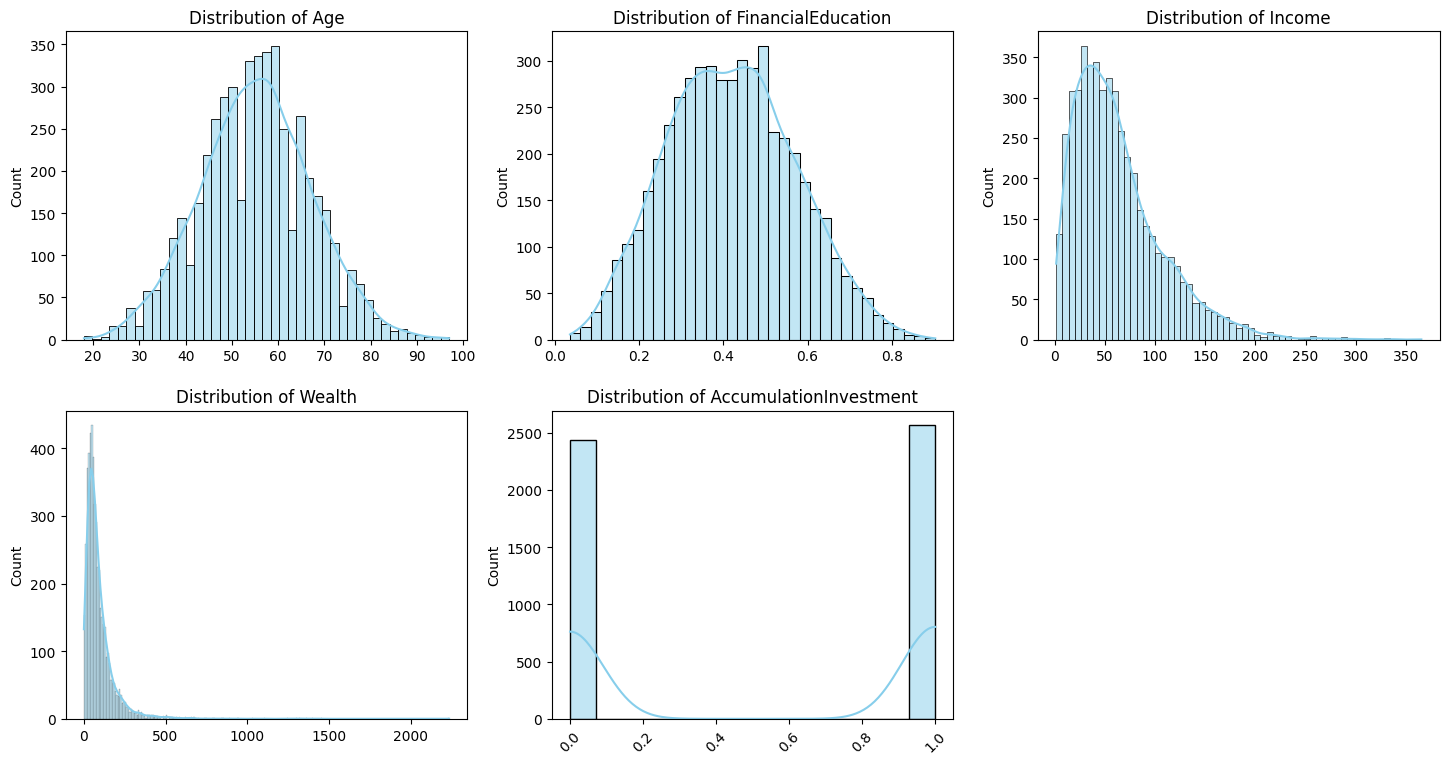

In [30]:
plot_feature_distributions(df_accumulation_selected_features)

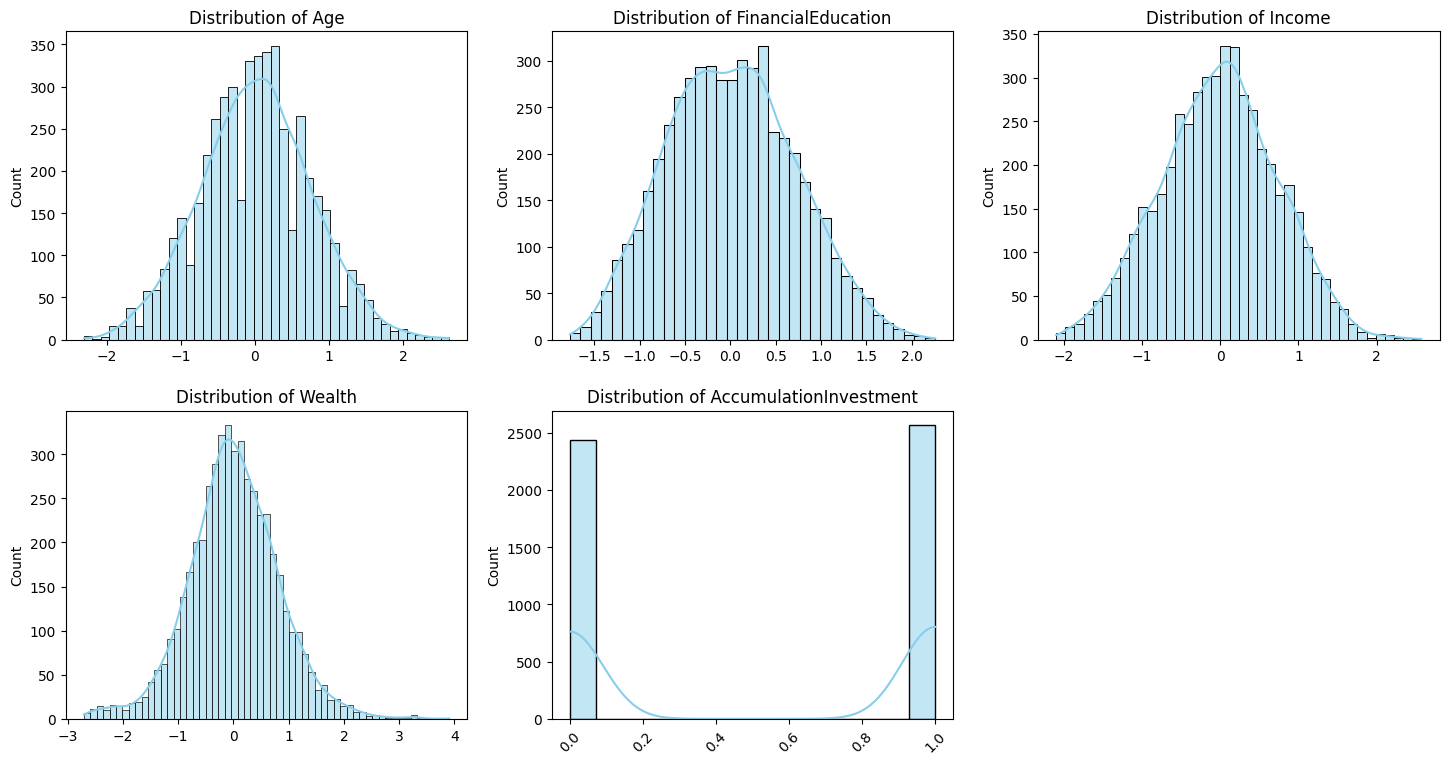

In [53]:
df_accumulation_selected_features_transformed = df_accumulation_selected_features.copy()
pt = PowerTransformer(method='yeo-johnson')
columns_yeo_johnson = ["Income", "Wealth"]
df_accumulation_selected_features_transformed[columns_yeo_johnson] = pt.fit_transform(df_accumulation_selected_features_transformed[columns_yeo_johnson])
scaler = RobustScaler()
numeric_cols = df_accumulation_selected_features_transformed.select_dtypes(include=['number']).columns.difference(["AccumulationInvestment"])
df_accumulation_selected_features_transformed = df_accumulation_selected_features_transformed.copy()
df_accumulation_selected_features_transformed[numeric_cols] = scaler.fit_transform(df_accumulation_selected_features_transformed[numeric_cols])
plot_feature_distributions(df_accumulation_selected_features_transformed)

## Save the data in excel

In [54]:
# Save the transformed DataFrame to an Excel file for the non transformed data
df_accumulation_selected_features.to_excel(
    "df_accumulation.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

In [55]:
# Save the transformed DataFrame to an Excel file for the transformed data
df_accumulation_selected_features_transformed.to_excel(
    "df_accumulation_preprocessed.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

# Income Investment Product

In [24]:
df_income = needs_df.copy()
df_income = df_income.drop(columns=['AccumulationInvestment'])
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,Male,Female
0,60,2,0.228685,0.233355,68.181525,53.260067,0,True,False
1,78,2,0.358916,0.170911,21.807595,135.550048,1,True,False
2,33,2,0.317515,0.249703,23.252747,66.303678,0,False,True
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False


In [25]:
df_income.corr(numeric_only=True)[['IncomeInvestment']]

,IncomeInvestment
Age,0.334249
FamilyMembers,0.041936
FinancialEducation,0.087424
RiskPropensity,0.063324
Income,0.208907
Wealth,0.384246
IncomeInvestment,1.000000
Male,0.013703
Female,-0.013703


## Comparison Basis

In [26]:
X = df_income.drop(columns=['IncomeInvestment'])  # Features
y = df_income['IncomeInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model without feature selection
# Initialize and train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.5906
Precision: 0.8459

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       619
           1       0.85      0.59      0.70       381

    accuracy                           0.80      1000
   macro avg       0.82      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000



## Crossed features

In [27]:
feature_combinations_income = {
    # Financial Capacity Features
    'Wealth / Income': lambda df: df['Wealth'] * df['Income'],
    'FinancialEducation * RiskPropensity': lambda df: df['FinancialEducation'] * df['RiskPropensity'],
    'RiskPropensity * Income': lambda df: df['RiskPropensity'] * df['Income'],
    'Income / FamilyMembers': lambda df: df['Income'] / df['FamilyMembers'],
    'Wealth / FamilyMembers': lambda df: (df['Wealth']) / df['FamilyMembers'],
}

# Create new features in df_income
for feature_name, func in feature_combinations_income.items():
    df_income[feature_name] = func(df_income)

In [44]:
df_income.head()

,Age,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,Male,Female,Wealth / Income,FinancialEducation * RiskPropensity,RiskPropensity * Income,Income / FamilyMembers,Wealth / FamilyMembers
0,60,2,0.228685,0.233355,68.181525,53.260067,0,True,False,3631.352562,0.053365,15.910476,34.090763,26.630033
1,78,2,0.358916,0.170911,21.807595,135.550048,1,True,False,2956.020562,0.061343,3.727167,10.903798,67.775024
2,33,2,0.317515,0.249703,23.252747,66.303678,0,False,True,1541.742689,0.079285,5.806282,11.626374,33.151839
3,69,4,0.767685,0.654597,166.189034,404.997689,1,False,True,67306.174793,0.502525,108.786897,41.547259,101.249422
4,58,3,0.429719,0.349039,21.186723,58.911930,0,True,False,1248.150713,0.149989,7.394994,7.062241,19.637310


## Forward Feature Selection

In [28]:
X = df_income.drop(columns=['IncomeInvestment'])  # Features
y = df_income['IncomeInvestment']                # Target (0 or 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
custom_scorer = make_scorer(balanced_recall_accuracy, alpha=0.8)  # Tune alpha!

# Initialize SFS with the custom scorer
sfs = SFS(
    RandomForestClassifier(random_state=42),
    k_features="best",
    forward=True,
    scoring="recall",  # Use the custom scorer
    cv=StratifiedKFold(3),  # Stratified K-Folds cross-validator
    n_jobs=-1,
    verbose=2
)

# Fit on training data
sfs.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.6s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  11 out of  13 | elapsed:    2.0s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    2.1s finished

[2025-04-09 04:11:03] Features: 1/13 -- score: 0.5367667214912281[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    1.5s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.9s finished

[2025-04-09 04:11:05] Features: 2/13 -- score: 0.6011830429662118[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  11 | elapsed:    1.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.4s finished

[2025-04-09 04:11:

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          k_features=(1, 13), n_jobs=-1, scoring='recall',
                          verbose=2)

In [30]:
# Get the best subset's performance
best_subset_key = list(sfs.subsets_.keys())[-1]  # The last key is the best subset
best_subset = sfs.subsets_[best_subset_key]

print("Best features:", sfs.k_feature_names_)
print("CV Recall (custom scorer):", best_subset['avg_score'])
print("CV Accuracy:", np.mean(best_subset['cv_scores']))  # Average across folds

Best features: ('Age', 'FinancialEducation', 'Income', 'Wealth', 'RiskPropensity * Income')
CV Recall (custom scorer): 0.608336886777128
CV Accuracy: 0.608336886777128


In [31]:
# Model without feature selection
selected_features = list(sfs.k_feature_names_)
rf.fit(X_train[selected_features], y_train)

# Make predictions
y_pred = rf.predict(X_test[selected_features])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.5801
Precision: 0.8599

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.86       619
           1       0.86      0.58      0.69       381

    accuracy                           0.80      1000
   macro avg       0.82      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000



## Exhaustive Feature Selection

In [32]:
# Initialize EFS
efs_income = EFS(
    RandomForestClassifier(random_state=42),
    min_features=3,          # Minimum features to test
    max_features=10,          # Maximum features to test (keep ≤4 for practicality)
    scoring=custom_scorer,        # Optimize recall (or 'accuracy', 'f1', etc.)
    cv=StratifiedKFold(5),                    # Cross-validation folds
    n_jobs=-1,               # Use all CPU cores
)

# Run EFS (this may take hours for large feature sets!)
efs_income.fit(X_train, y_train)

Features: 8008/8008

ExhaustiveFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                          estimator=RandomForestClassifier(random_state=42),
                          feature_groups=[[0], [1], [2], [3], [4], [5], [6],
                                          [7], [8], [9], [10], [11], [12]],
                          max_features=10, min_features=3, n_jobs=-1,
                          scoring=make_scorer(balanced_recall_accuracy, response_method='predict', alpha=0.8))

In [33]:
# Results
print("Best feature subset:", efs_income.best_idx_)          # Feature indices
print("Best feature names:", efs_income.best_feature_names_) # Feature names
print("Best CV recall:", efs_income.best_score_)             # Cross-validated recall

Best feature subset: (0, 3, 4, 5, 6, 8, 9, 10)
Best feature names: ('Age', 'RiskPropensity', 'Income', 'Wealth', 'Male', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'RiskPropensity * Income')
Best CV recall: 0.6562964253987056


In [34]:
rf.fit(X_train[list(efs_income.best_feature_names_)], y_train)

# Make predictions
y_pred = rf.predict(X_test[list(efs_income.best_feature_names_)])

# Compute metrics
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Print results
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Recall: 0.5827
Precision: 0.8473

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.94      0.85       619
           1       0.85      0.58      0.69       381

    accuracy                           0.80      1000
   macro avg       0.82      0.76      0.77      1000
weighted avg       0.81      0.80      0.79      1000



## Data Set cleaning

In [45]:
selected_features_income = ['Age', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'RiskPropensity * Income']
df_income_selected_features = df_income[selected_features_income + ['IncomeInvestment']]
df_income_selected_features.head()

,Age,FinancialEducation,RiskPropensity,Income,Wealth,Wealth / Income,FinancialEducation * RiskPropensity,RiskPropensity * Income,IncomeInvestment
0,60,0.228685,0.233355,68.181525,53.260067,3631.352562,0.053365,15.910476,0
1,78,0.358916,0.170911,21.807595,135.550048,2956.020562,0.061343,3.727167,1
2,33,0.317515,0.249703,23.252747,66.303678,1541.742689,0.079285,5.806282,0
3,69,0.767685,0.654597,166.189034,404.997689,67306.174793,0.502525,108.786897,1
4,58,0.429719,0.349039,21.186723,58.911930,1248.150713,0.149989,7.394994,0


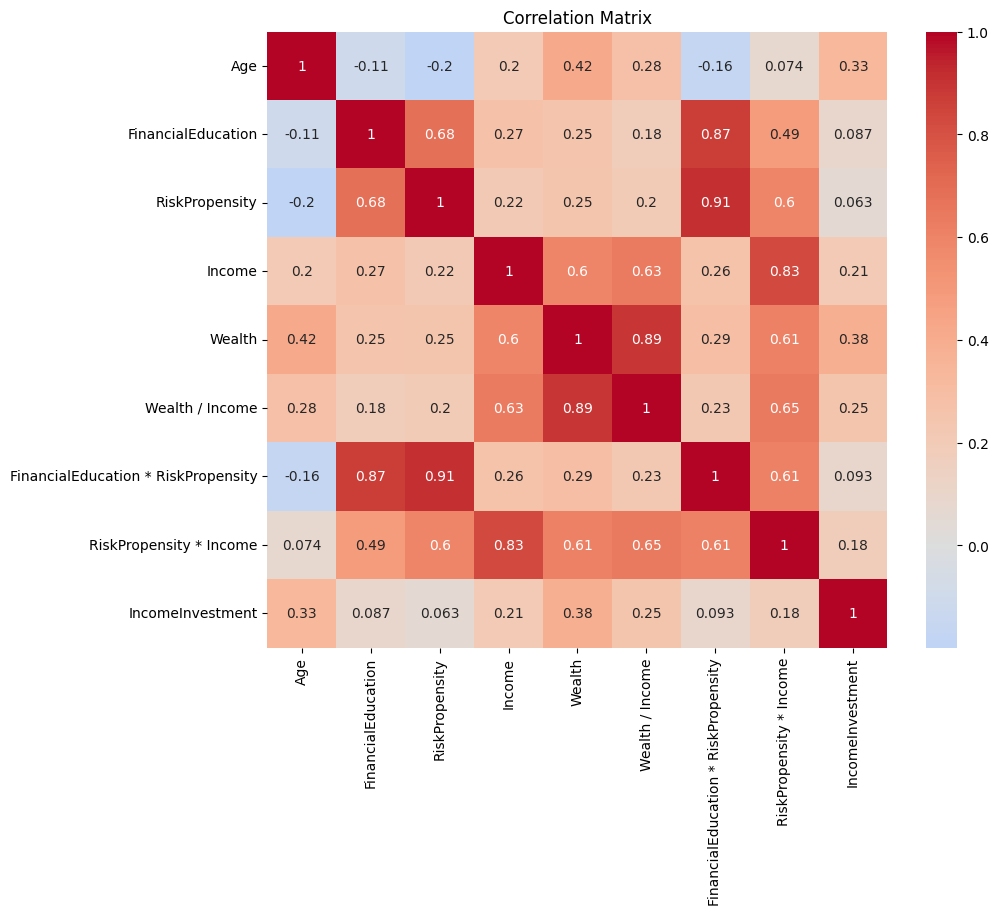

In [46]:
plot_correlation_matrix(df_income_selected_features)

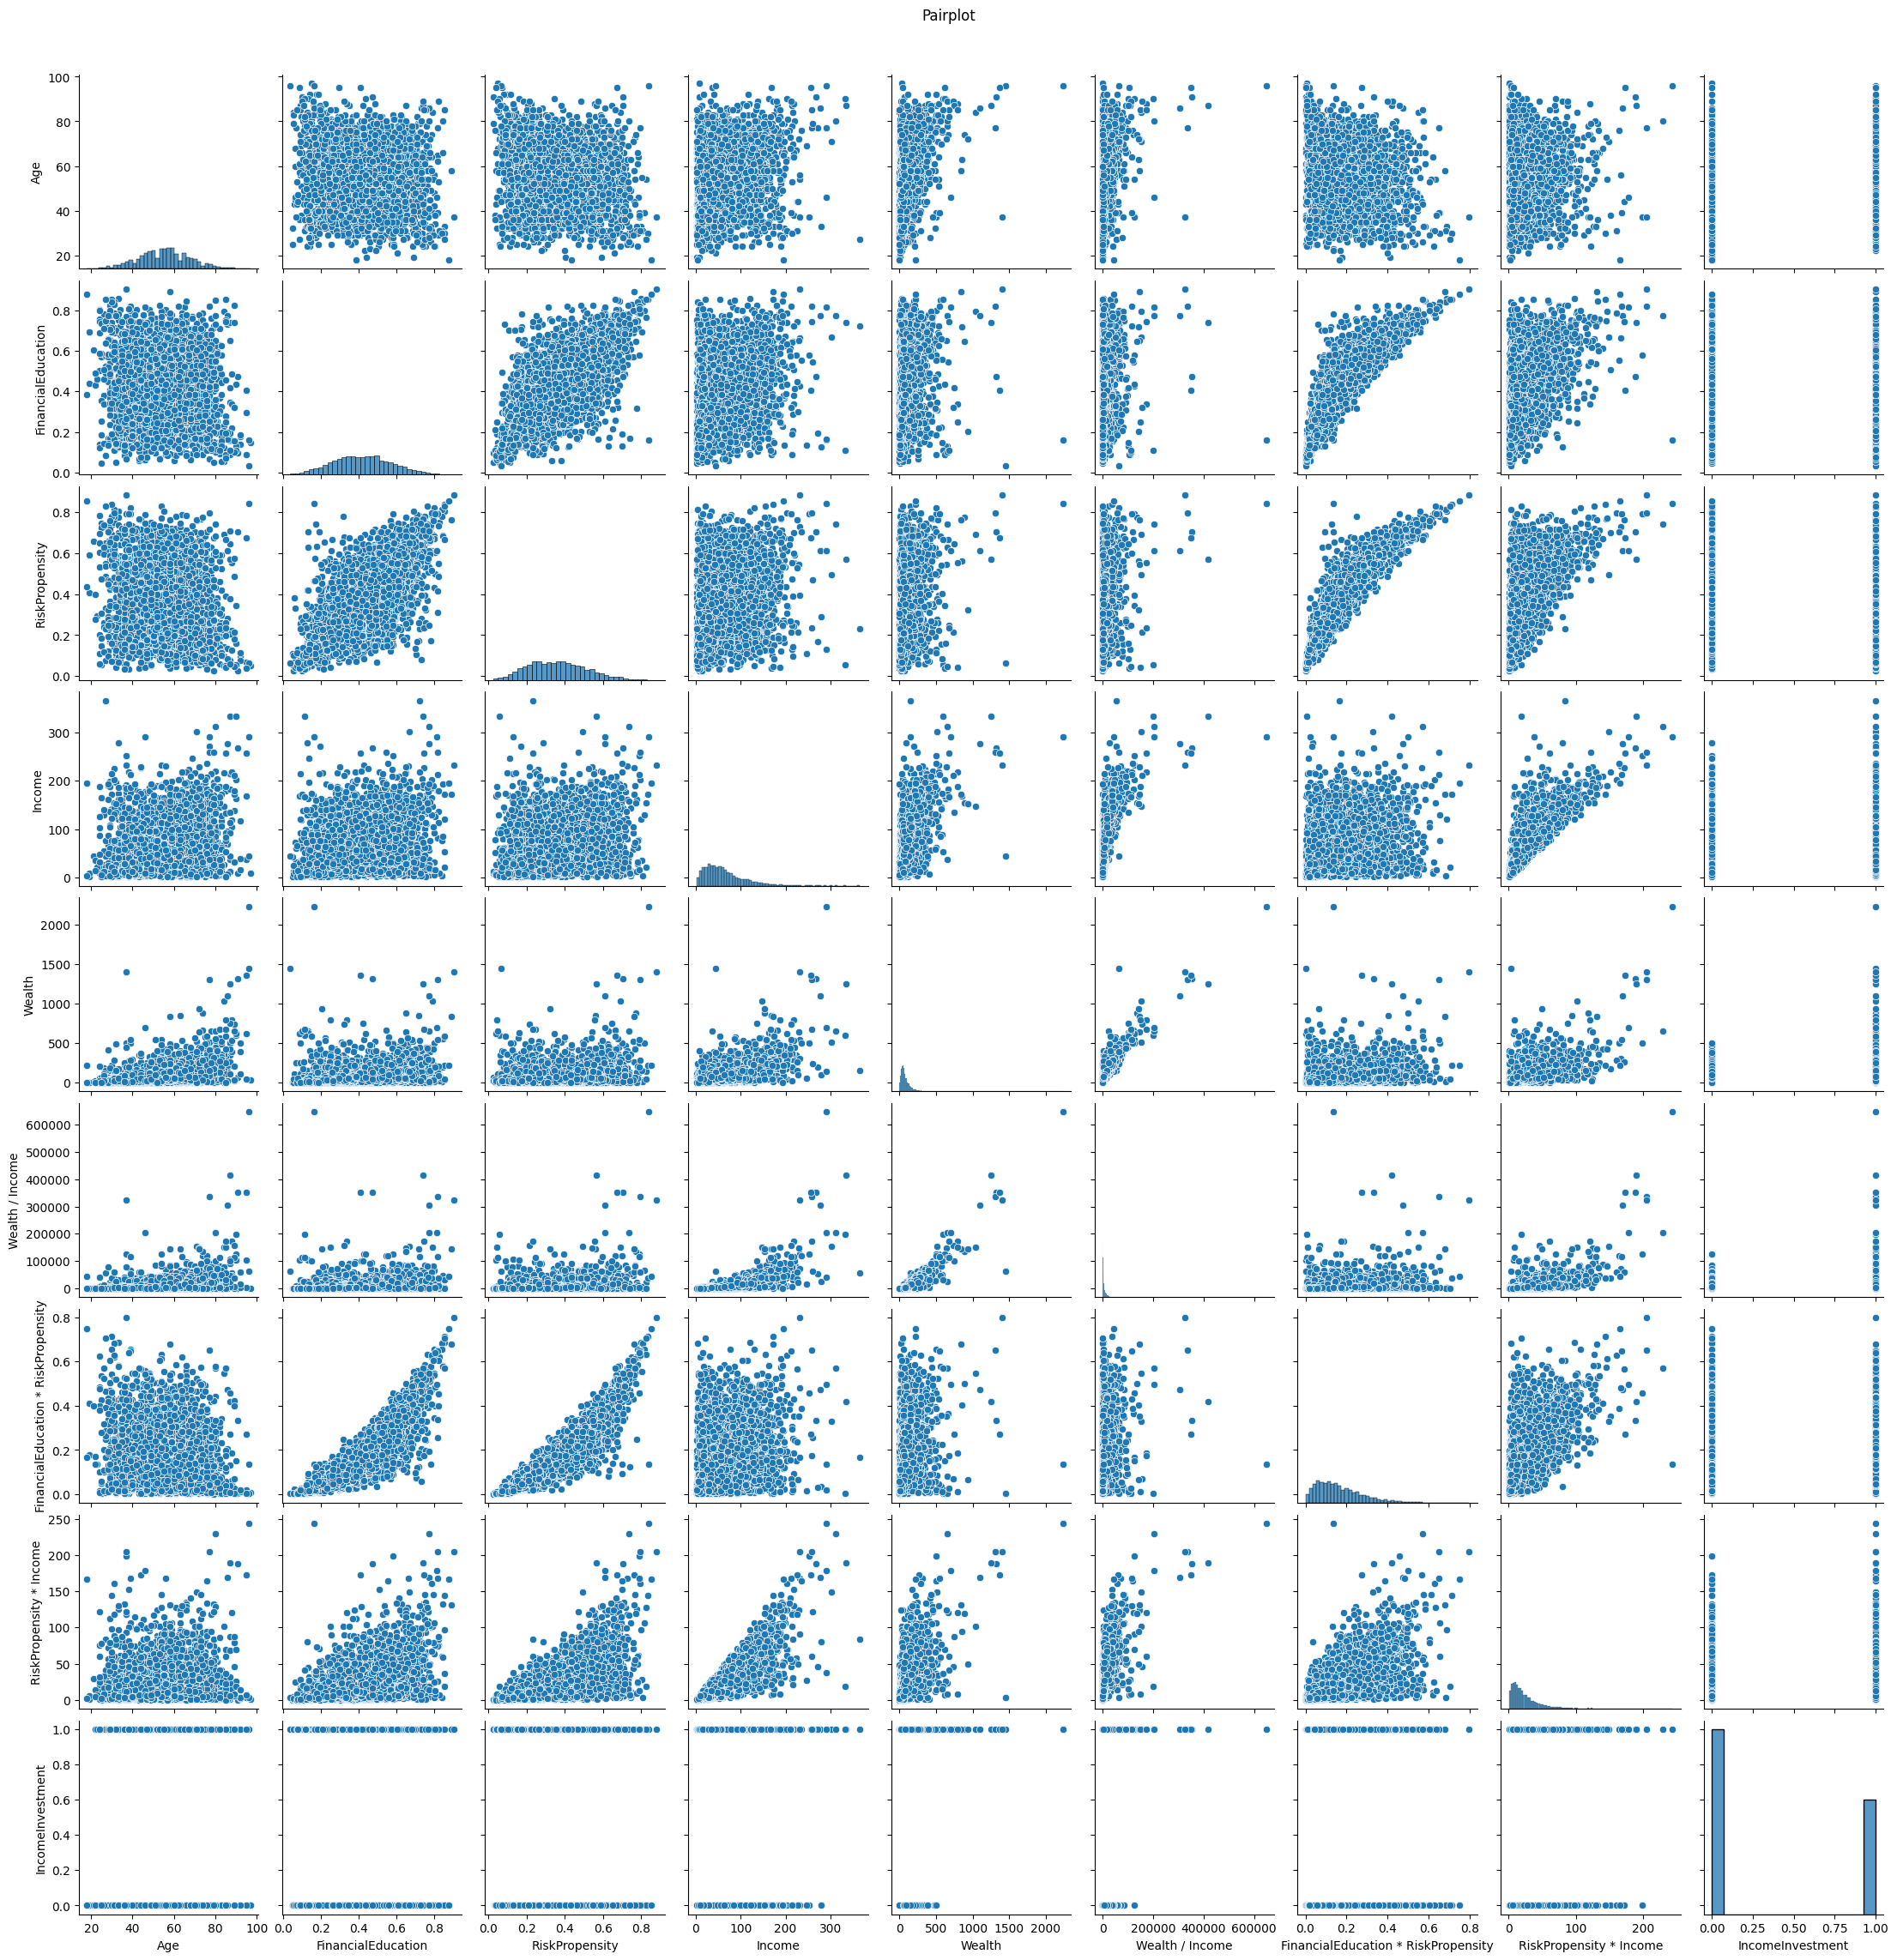

In [47]:
plot_pairplot(df_income_selected_features)

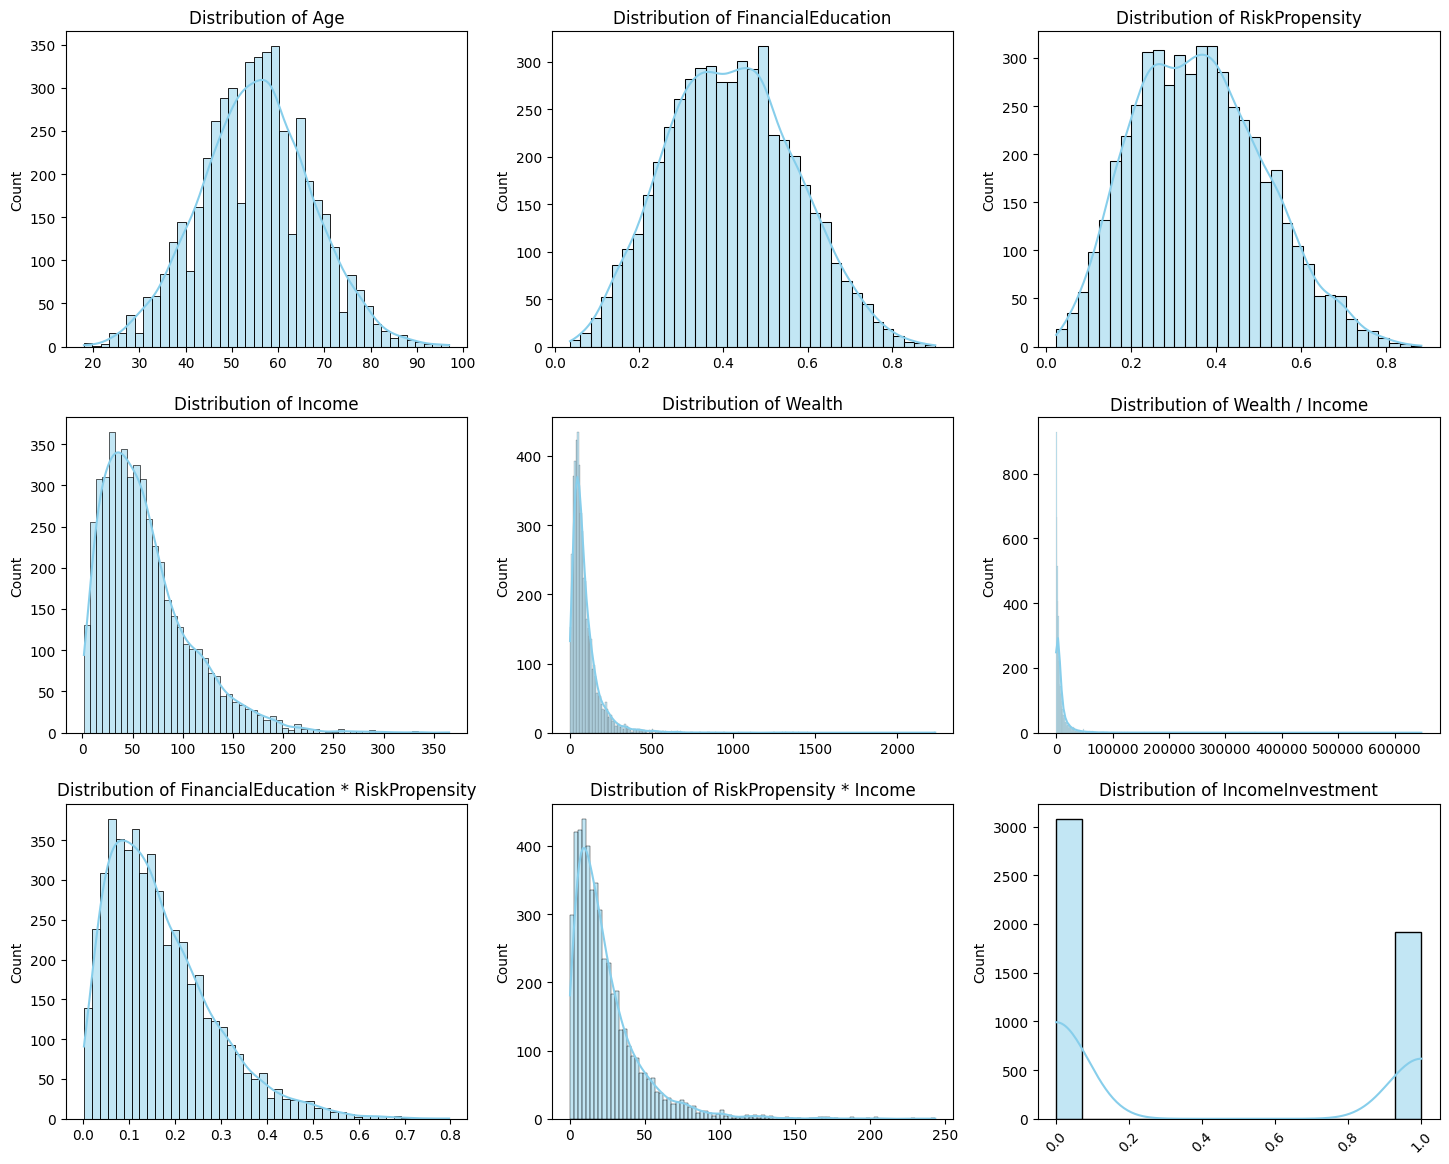

In [48]:
plot_feature_distributions(df_income_selected_features)

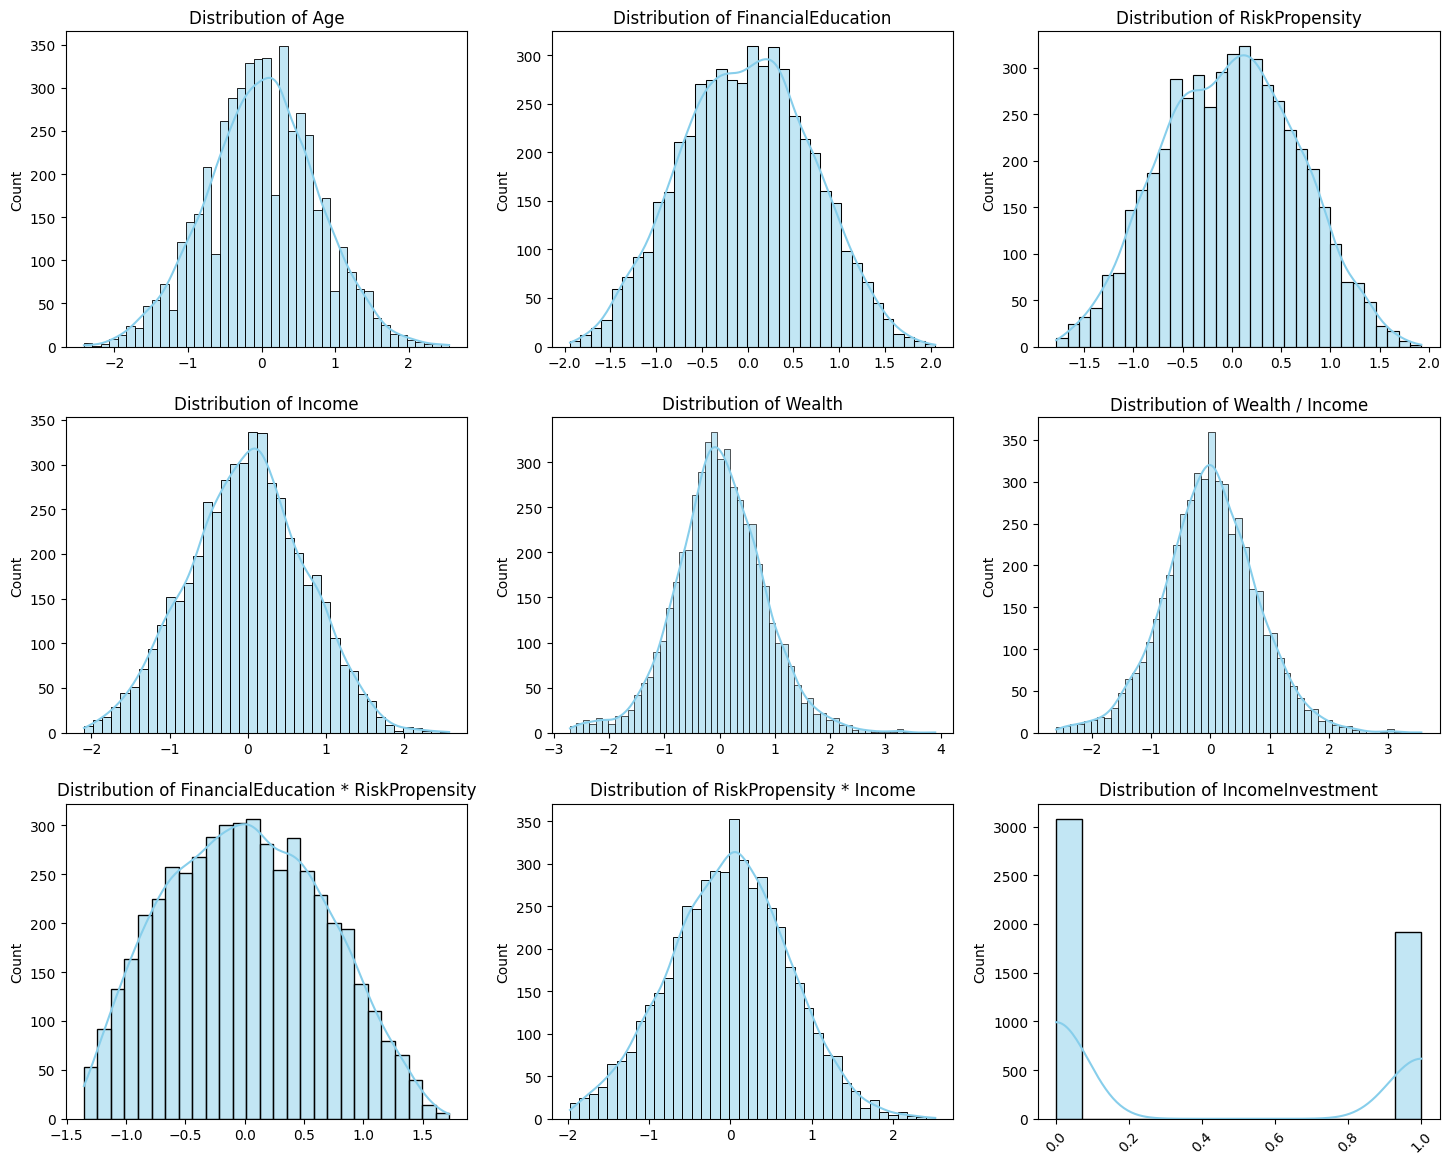

In [56]:
df_income_selected_features_transformed = df_income_selected_features.copy()
pt = PowerTransformer(method='yeo-johnson')
columns_yeo_johnson = ['Age', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth', 'Wealth / Income', 'FinancialEducation * RiskPropensity', 'RiskPropensity * Income']
df_income_selected_features_transformed[columns_yeo_johnson] = pt.fit_transform(df_income_selected_features_transformed[columns_yeo_johnson])
scaler = RobustScaler()
numeric_cols = df_income_selected_features_transformed.select_dtypes(include=['number']).columns.difference(["AccumulationInvestment"])
df_income_selected_features_transformed[numeric_cols] = scaler.fit_transform(df_income_selected_features_transformed[numeric_cols])
plot_feature_distributions(df_income_selected_features_transformed)

## Save the data in excel

In [57]:
# Save the transformed DataFrame to an Excel file for the non transformed data
df_income_selected_features.to_excel(
    "df_income.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)

In [58]:
# Save the transformed DataFrame to an Excel file for the transformed data
df_income_selected_features_transformed.to_excel(
    "df_income_preprocessed.xlsx",
    index=False,
    sheet_name="ProcessedData"  # Optional: customize sheet name
)